### Imports 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, BatchNormalization,AveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.regularizers import l1, l2, l1_l2


### Constants

In [30]:
base_path = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/data_splits")
split_variants = {
    # "5pct_80": base_path / "5pct_80",
    "15pct_80": base_path / "15pct_80",
    # "25pct_80": base_path / "25pct_80"
}

### CNN Model Build

In [31]:
def build_paper_cnn(input_shape):
    reg_strength = 0.07473443812560776 

    model = Sequential([
        Input(shape=input_shape),

        Conv1D(64, kernel_size=2, strides=2, activation='relu',
               kernel_regularizer=l2(reg_strength)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2, strides=2),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(reg_strength)),
        Dropout(0.07),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### CNN Trainer Function

In [32]:
def train_and_evaluate_cnn(X_train, X_test, y_train, y_test, variant):
    X_train_cnn = X_train.values[..., np.newaxis]
    X_test_cnn = X_test.values[..., np.newaxis]

    model = build_paper_cnn(input_shape=X_train_cnn.shape[1:])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # class_weights = {0: 1, 1: 3}

    history = model.fit(
        X_train_cnn, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        # class_weight=class_weights,
        verbose=1
    )

    y_pred = (model.predict(X_test_cnn) > 0.5).astype(int).flatten()

    print(f"\nResults for {variant}")
    print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {variant}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return round(accuracy_score(y_test, y_pred), 4)

### Run across 5 splits


==== Running CNN on 15pct_80 ====
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.5592 - loss: 28.3297 - val_accuracy: 0.6829 - val_loss: 18.0076
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8206 - loss: 17.4753 - val_accuracy: 0.5976 - val_loss: 13.3063
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8534 - loss: 11.9718 - val_accuracy: 0.6585 - val_loss: 8.2811
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9665 - loss: 6.9003 - val_accuracy: 0.6220 - val_loss: 5.1243
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9554 - loss: 4.1422 - val_accuracy: 0.7073 - val_loss: 3.4507
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9271 - loss: 2.9791 - val_accuracy: 0.7805 - val_loss: 3.0079
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8934 - loss: 3.2168 - val_accuracy: 0.7927 - val_loss: 4.0195
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8834 -

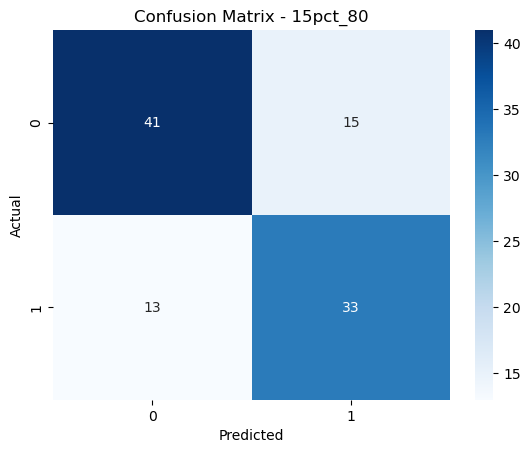

In [33]:
results = []
for name, path in split_variants.items():
    print(f"\n==== Running CNN on {name} ====")
    X_train = pd.read_csv(path / "X_train.csv", index_col=0)
    X_test = pd.read_csv(path / "X_test.csv", index_col=0)
    y_train = pd.read_csv(path / "y_train.csv", index_col=0).squeeze()
    y_test = pd.read_csv(path / "y_test.csv", index_col=0).squeeze()

    acc = train_and_evaluate_cnn(X_train, X_test, y_train, y_test, name)
    results.append((name, X_train.shape[1], acc))


In [34]:
# Final summary
df_cnn_results = pd.DataFrame(results, columns=["Split", "Num Features", "Test Accuracy"])
df_cnn_results = df_cnn_results.sort_values("Test Accuracy", ascending=False).reset_index(drop=True)

print("\Final CNN Test Accuracy Comparison:")
df_cnn_results

\Final CNN Test Accuracy Comparison:


,Split,Num Features,Test Accuracy
0,15pct_80,5870,0.7255
